[ddpg-algorithm]: https://user-images.githubusercontent.com/3620840/119758155-ee57d600-be5a-11eb-8b19-59fab595fbe1.png "DDPG Algorithm"
[reinforcement-learning]: https://user-images.githubusercontent.com/3620840/114342627-0379df00-9b11-11eb-83d5-cc2773145c8c.jpg "Reinforcement Learning"
[mc-control]: https://user-images.githubusercontent.com/3620840/114350423-08915b00-9b1e-11eb-8cf4-9eb2abd72a33.png "MC Control"



# Project description

This project uses deep reinforcement learning to teach a double jointed arm to move to a target location. The goal is achieve by using Deep Reinforcement Learning. More especifically, we use an Actor-Critic based algorithm called [Deep Deterministic Policy Gradient (DDPG)](https://arxiv.org/pdf/1509.02971.pdf).

The global parameters for the training are specified in the file agent.py and copied here for simplicity.

## Parameters

```
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
```

## Reinforcement Learning

In Reinforcement Learning, in a given instant in time, an agent gets its current state $s$ and based on it decides on an action $a$ to take. After taking the action, the agent gets a reward $r_{t+1}$ and its state changes to $s_{t+1}$. The reward and the new state of the agent depend on the current state and the action that was selected. This process is sintetized in the formula and image below.

$$(s_t, a_t) => (r_{t+1}, s_{t+1})$$

![Reinforcement learning][reinforcement-learning]

The goal of the agent is to choose a set of actions that will lead to the biggest cumulative return. The cumulative return is the sum of all the rewards collected by the agent while performing the actions and switching states. The cumulative return the agent gets is calculated as below.

$$G_t = R_{t + 1} + R_{t + 2} + R_{t + 3} + R_{t + 4} + ... + R_{t + n}$$

One problem of calculating the cumulative return this way is that a reward in the future is as valuable as a reward now. The agent should rely more on its more reliable closest rewards than the ones far in the future. To achieve that, we can introduce a discount factor `GAMMA` $\gamma$ to decrease the weight of future rewards. The new discounted cumulative return is calculated as follows.

$$G_t = R_{t + 1} + \gamma R_{t + 2} + \gamma^2 R_{t + 3} + \gamma^3 R_{t + 4} + ... + \gamma^{n-1} R_{t + n}$$

The value of $\gamma$ should be between 0 and 1. If set to 0, all future rewards are not taken into account and the agent only considers its most imediate reward. On the other extreme, setting $\gamma$ to 1, this equation turns back to its inital form where it considers imediate rewards as valuable as future rewards.

The agent choses the actions based on a policy:
$$\pi(s) => a$$

The policy maps a state to an action. One way to implement the policy is to maintain a Q-table with size (# states) x (# actions). Each entry on the table represents the expected cumulative future return the agent gets if it takes an action $a$ given it is on state $s$. This value can be accessed on the Q-Table\[state\]\[action\]. The expected cumulative future return corresponds to the sum of the imediate reward the agent gets from taking action $a$ while on state $s$ plus the expected reward from ending up on state $s_{t + 1}$ and choose the next actions following the policy $\pi$.

$$(s, a) => (r, s')$$

$$Q(s, a) = r + Q(s_{t + 1}, \pi(s_{t + 1}))$$


## Deep Reinforcement Learning (Actor-Critic Based Method)

As the name suggests, an Actor-Critic agent is composed by an actor network and a critic network.

### Actor

The actor implements a policy based reinforcement learning method. This means that the actor aims to approximate the optimal policy directly. Given the current state of the agent, the actor outputs the best action to take. It can be represented by the function:

$$\mu(s;\theta^u)$$

where $\theta_u$are the parameters of the actor neural network.

### Critic

The critic implements a value based reinforcement learning method. This means that the critic aims to approximate the expected cumulative return. It gets as input the current state of the agent and an action and outputs the expected cumulative return of that state, action pair. It can be represented by the function:

$$Q(s, \mu(s;\theta^u); \theta^Q)$$

where $\theta_Q$are the parameters of the critic neural network.

### Training

To train both the agent and the critic, this algorithm uses a [Experience Replay Buffer](http://files.davidqiu.com//research/nature14236.pdf) of size `BUFFER_SIZE`. At each step `BATCH_SIZE` memories are randomly selected from the buffer and used to update the parameters of both networks.

It is important to notice that this algorithm uses two separate networks with distinct parameters both for the actor and the critic. This gives us a total of 4 different sets of parameters that are $\theta^u$ (local actor), $\theta^{u^i}$ (target actor), $\theta^Q$ (local critic), $\theta^{Q^i}$ (target critic). After training the local networks with the experiences from the replay buffer, a soft update of the target networks is performed. In this case, a soft copy is used and controlled by the TAU parameter. The bigger the value of  𝜏  (up to 1), the closer the local and the target network get after the soft update. This process of using two separate networks is used to increase the stability of the training step by fixing the target network while updating the local network. This method if fully described on the [Deep Q-Network](http://files.davidqiu.com//research/nature14236.pdf) article.

The full [DDPG training algorithm](https://arxiv.org/pdf/1509.02971.pdf) is described below.

![DDPG Algorithm][ddpg-algorithm]

### Model

This project uses two Fully Connected Neural Networks for both the actor and the critic. 

The actor is a FCNN with input size `state_size`, followed by two hidden layers of size 128. A `relu` function is used on the output of each of the three first layers. The output layer has size `action_size`. All the actions range from -1 to 1, so we chose to use a `tanh` activation function on the output layer.

The critic input layer is implemented following the description of the DDPG paper. It first has an input layer of size `state_size`. The difference here is that the first hidden layer receives as input the output of the input layer plus the action vector, which makes it have size `128 + action_size`. The output of the first hidden layer is then used as input for the second hidden layer without modifications. After each of the first three layers, a `relu` function is used. The critic output layer has size 1, which corresponds to the expected cumulative return for the (state, action) pair provided as input.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

In [2]:
def moving_average(data, size):
    return np.convolve(data, np.ones(size), mode='valid') / size

ddpg reached goal on episode 132


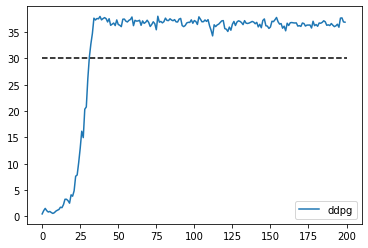

In [3]:
models = ['ddpg']

plot_size = 200
goal = 30
maintain_goal_for = 100

for model_name in models:
    scores_file_path = os.path.join('checkpoints', f'score_{model_name}.pkl')
    scores = np.array(pickle.load(open(scores_file_path, 'rb'))[:plot_size])
    
    goal_index = np.where(scores > goal)[0]
    goal_average = moving_average(np.diff(goal_index), maintain_goal_for)
    goal_maintained = np.where(goal_average == 1)[0]
    if goal_index.any() and goal_maintained.any():
        print(f'{model_name} reached goal on episode {goal_index[0] + goal_maintained[0] + maintain_goal_for + 1}')
    else:
        print(f'{model_name} did not reach the goal')
    
    plt.plot(range(len(scores)), scores, label=model_name)

plt.hlines(goal, 0, plot_size, color='black', linestyles='dashed')
plt.legend()
plt.show()

## Results

Above you can see the score achived by the agent at each time step during training. This results use the version 2 of the environment where 20 agents are present. At each time step the rewards coming from each agent are averaged over the number of agents. The agent was able to first achieve the goal of +30 reward at the step 32 and maintained itself above this threshold until the end of the training at step 200. The environment is considered complete when the agent is able to maintain a score of +30 for at least 100 consecutive episodes, which happened at the episode 132.

## Future Work

There is an improvement over the `UniformReplayBuffer` that was used to train the models above called [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952) (PER). In this second method, the experiences are sampled using a priority proportional to their TD-error.

One improvement descrived in the [DDPG paper](https://arxiv.org/pdf/1509.02971.pdf) is to use batch normalization, This technique standardizes the input batch which can help stabilize the training.

This project could be further improved by implementing [Twin-Delayed DDPG (TD3)](https://arxiv.org/pdf/1802.09477.pdf). This algorithm offers that introduces state-of-the-art improvements to DDPG. There are also other algorithms like [Distributed Distributional Deterministic Policy Gradients (D4PG)](https://openreview.net/forum?id=SyZipzbCb) and [Trust Region Policy Optimization (TRPO)](https://arxiv.org/abs/1502.05477) that have shown better results than DDPG in other environments.

Also, a benchmark of Deep Reinforcement methods for Continuous Control can be accessed [here](https://arxiv.org/abs/1604.06778).